In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, model_selection
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import pickle

In [2]:
df = pd.read_csv('GOOG.csv', delimiter=',')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
749,2020-07-29,1506.319946,1531.251953,1501.329956,1522.020020,1522.020020,1106500
750,2020-07-30,1497.000000,1537.869995,1492.219971,1531.449951,1531.449951,1671400
751,2020-07-31,1505.010010,1508.949951,1454.030029,1482.959961,1482.959961,3439900
752,2020-08-03,1486.640015,1490.469971,1465.640015,1474.449951,1474.449951,2330200
753,2020-08-04,1476.569946,1485.560059,1458.650024,1464.969971,1464.969971,1902200


In [3]:
# Close and Adj Close hold the same values
for item1, item2 in zip(df['Close'], df['Adj Close']):
    result = (item1 == item2)
print(result)

True


In [4]:
df['Pct_Change'] = (df['Close'] - df['Open']) / df['Open']*100

In [5]:
df.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Pct_Change    0
dtype: int64

In [6]:
df_copy = df.copy()[['Open', 'Close', 'Pct_Change']]

In [7]:
# Forecast 7 days into the future
forecast_col = 'Close'
forecast_out = 7
df_copy['Prediction'] = df[forecast_col].shift(-forecast_out)
print(df_copy)

            Open        Close  Pct_Change  Prediction
0     929.059998   929.359985    0.032289  926.960022
1     927.090027   926.789978   -0.032365  910.979980
2     920.609985   922.900024    0.248752  910.669983
3     917.549988   907.239990   -1.123644  906.659973
4     907.969971   914.390015    0.707077  924.690002
..           ...          ...         ...         ...
749  1506.319946  1522.020020    1.042280         NaN
750  1497.000000  1531.449951    2.301266         NaN
751  1505.010010  1482.959961   -1.465110         NaN
752  1486.640015  1474.449951   -0.819974         NaN
753  1476.569946  1464.969971   -0.785603         NaN

[754 rows x 4 columns]


Notice the last few lines of Prediction column are NaN, this is because I am training the model to predict 7 days into the future with `shift`.

In [8]:
# X is features to predict y, y is the price of Google stocks in the future
x = np.array(df_copy.drop(['Prediction'], 1))
x = preprocessing.scale(x)
x_recent = x[-forecast_out:]
x = x[:-forecast_out]

y = np.array(df_copy['Prediction'])
y = y[:-forecast_out]

I am ready to start training.

Due to the test sizing process, the model is going to return a different result every time, so let's run it 800 times to get the model with best accuracy. Then, I can create a pickle file and store the model, so I can use it later.

In [9]:
best = 0
for __ in range(800):
    x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)
    linear = LinearRegression()
    linear.fit(x,y)
    accuracy = linear.score(x_test, y_test)
    if accuracy > best:
        best = accuracy
        with open("google_regression.pickle", "wb") as f:
            pickle.dump(linear, f)

pickle_in = open("google_regression.pickle", "rb")
linear = pickle.load(pickle_in)
print(f'Accuracy:{best}')

Accuracy:0.9343151969589045


In [10]:
forecast = linear.predict(x_recent)
print(forecast)

[1519.45341714 1487.71136455 1511.70487559 1522.02275118 1471.58916462
 1464.35213799 1455.42244925]


These are the predicted prices of Google stocks for the **next 7 days**

In [11]:
# Now that I got predicted values, let's plot the data 
df = df[['Date', 'Close']]

df['Date'] = pd.to_datetime(df['Date'])
forecast_date = pd.date_range('2020-08-05', periods=forecast_out, freq='D')
predict_df = pd.DataFrame({'Date':forecast_date, "Close":forecast})
# put dataframes into one
df = df.append(predict_df)
df.reset_index(inplace=True, drop=True)
print(f'Original Table \n{df.tail(10)}')

Original Table 
          Date        Close
751 2020-07-31  1482.959961
752 2020-08-03  1474.449951
753 2020-08-04  1464.969971
754 2020-08-05  1519.453417
755 2020-08-06  1487.711365
756 2020-08-07  1511.704876
757 2020-08-08  1522.022751
758 2020-08-09  1471.589165
759 2020-08-10  1464.352138
760 2020-08-11  1455.422449


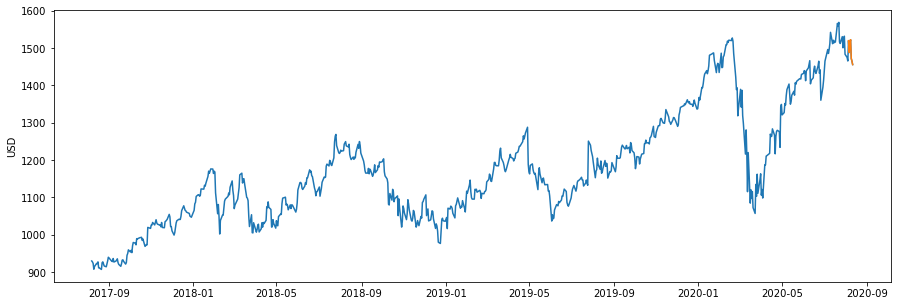

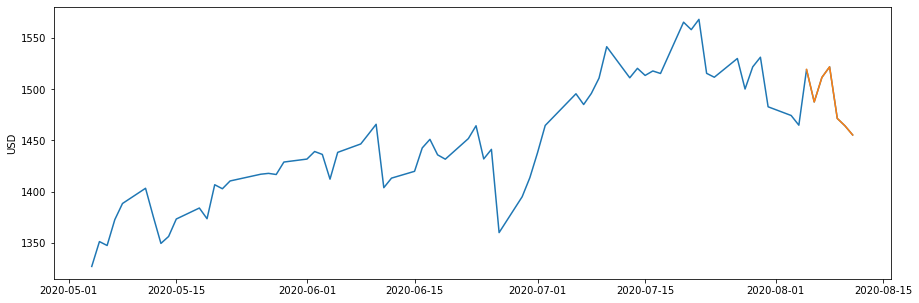

In [12]:
plt.rcParams['figure.figsize'] = [15, 5]
forecast_df = df.loc[df['Date'] > '20200501']
plt.plot('Date', 'Close', data=df)
plt.plot('Date', 'Close', data=predict_df)
plt.ylabel('USD')
plt.show()
plt.plot('Date', 'Close', data=forecast_df)
plt.plot('Date', 'Close', data=predict_df)
plt.ylabel('USD')
plt.show()